In [1]:
import csv
import regex
import datetime as dt
import locale
locale.setlocale(locale.LC_TIME, 'id-ID.UTF-8')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

#from feature_engine.outlier_removers import Winsorizer

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("Data/Dashboard Ternakmart_Transaction Details 2020 (raw).csv")
# df = pd.read_csv("Data/Dashboard Ternakmart_Transaction Details_2019-07to09.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27025 entries, 0 to 27024
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   delivery_date    27025 non-null  object 
 1   delivery_status  26813 non-null  object 
 2   no_order         26813 non-null  object 
 3   Channel          26813 non-null  object 
 4   ID CL            17078 non-null  float64
 5   nama_komunitas   13473 non-null  object 
 6   name             26813 non-null  object 
 7   username         26809 non-null  object 
 8   useremail        26809 non-null  object 
 9   telp             26813 non-null  object 
 10  prod_id          26813 non-null  float64
 11  produk           26813 non-null  object 
 12  harga            26813 non-null  float64
 13  qty              26813 non-null  float64
 14  subtotal         26813 non-null  float64
dtypes: float64(5), object(10)
memory usage: 3.1+ MB


# Cleaning

In [4]:
#standarize telp number
number_not_standard = '08'
number_standard = '62'
df['telp'] = df['telp'].str.replace('-','')
df['telp'] = df['telp'].str.replace(' ','')
df['telp'] = df['telp'].str.replace('+','')
df['telp'] = df['telp'].str.replace('08', '62', 1)

In [ ]:
df.head(10)

In [5]:
df = df[df.delivery_status.eq('delivered')]
#Clean Old B2B Channel
B2B_key = ['hotel', 'resto', 'restoran', 'cafe', 'Toko', 'toko', 'Patata', 
           'Geprek', 'Laziza', 'sego', 'Baksoe', 'Bakso', 'Rismart',
           'Nu Mart', 'Warung', 'Rice box', 'E-Warung', 'ewarung', 'Kedai',
           'nelongso', 'pkk']
df = df[~df['name'].str.contains('|'.join(B2B_key))] #Clean Based on Channel
channel = ['CL', 'End User', 'Shopee']
df = df[df['Channel'].isin(channel)]

#Clean penyesuaian dan test
testing = ['test', 'penyesuaian', 'penyelamatan', 'TEXTING ']
df = df[~df['name'].str.contains('|'.join(testing))]
# df = df[~df['username'].str.contains('TEXTING')]

(22874, 15)

In [6]:
#Clean admin no hp & Invalid
df = df[~df['telp'].eq('6281381306699')]
df = df[~df['telp'].eq('0')]
df = df[df['telp'].str.startswith('62')]
        
# #Clean admin user
# df = df[~df['username'].eq('Ternakfresh Indonesia')]
# print('Count username : ' + str(len(pd.unique(df['username']))))
# print('Count no_order : ' + str(len(pd.unique(df['no_order']))))

In [8]:
#Clean produk gratis
df = df[df['harga']>0]

#Cleaning outlier (Paket donasi sembako)
## need futher data based technique
df = df[~(df['subtotal'] > 2500000)]  

df.shape

(20781, 15)

In [9]:
print('Unique telp : ' + str(len(pd.unique(df['telp']))))
print('Unique no_order : ' + str(len(pd.unique(df['no_order']))))

Unique telp : 2424
Unique no_order : 9173


In [10]:
#parse datetime format
df['delivery_date'] = df['delivery_date'].apply(lambda x:dt.datetime.strptime(x,'%d %b %Y'))
df.head(10)

,delivery_date,delivery_status,no_order,Channel,ID CL,nama_komunitas,name,username,useremail,telp,prod_id,produk,harga,qty,subtotal
3,2020-01-02,delivered,Z37DISI,End User,NaN,NaN,Bu Lena,Ternakfresh Indonesia,ternakmart@gmail.com,621381306699,65.0,JAB FROZEN YOGURT,20000.0,1.0,20000.0
4,2020-01-02,delivered,Z37DISI,End User,NaN,NaN,Bu Lena,Ternakfresh Indonesia,ternakmart@gmail.com,621381306699,98.0,TELUR AYAM NEGERI KG,23000.0,1.0,23000.0
5,2020-01-02,delivered,Z37DISI,End User,NaN,NaN,Bu Lena,Ternakfresh Indonesia,ternakmart@gmail.com,621381306699,148.0,Daging Ayam (Broiler) 1.0 kg,30000.0,1.0,30000.0
6,2020-01-02,delivered,Z37EKGJ,End User,NaN,NaN,Bu Sum,Saktian Eryananta,saktian.eryananta@gmail.com,625735055997,154.0,TELUR AYAM NEGERI 10KG,217000.0,3.0,651000.0
8,2020-01-02,delivered,Z37FBLZ,End User,NaN,NaN,Bu Sri Pasar Menur Pumpungan,Ternakfresh Indonesia,ternakmart@gmail.com,621381306699,154.0,TELUR AYAM NEGERI 10KG,215000.0,1.0,215000.0
9,2020-01-02,delivered,Z37HIMO,End User,NaN,NaN,bu yakult,Achmad Chabib Syaiful Basri,achmadhabib70@gmail.com,625733849229,98.0,TELUR AYAM NEGERI KG,23500.0,2.0,47000.0
11,2020-01-02,delivered,Z37IDLG,End User,NaN,NaN,Zakia Puspa Ramdhani,Ternakfresh Indonesia,ternakmart@gmail.com,621381306699,61.0,JAB YOGURT LECI 250ML,7500.0,1.0,7500.0
12,2020-01-02,delivered,Z37IDLG,End User,NaN,NaN,Zakia Puspa Ramdhani,Ternakfresh Indonesia,ternakmart@gmail.com,621381306699,65.0,JAB FROZEN YOGURT,18000.0,2.0,36000.0
16,2020-01-02,delivered,Z37MFBR,End User,NaN,NaN,Bu Sri Pasar Menur Pumpungan,Saktian Eryananta,saktian.eryananta@gmail.com,625735055997,154.0,TELUR AYAM NEGERI 10KG,215000.0,1.0,215000.0
17,2020-01-02,delivered,Z37NTHU,End User,NaN,NaN,bu siti manyar jaya 9. no ...,Achmad Chabib Syaiful Basri,achmadhabib70@gmail.com,625733849229,98.0,TELUR AYAM NEGERI KG,23500.0,1.0,23500.0


# Generate LRFM

In [11]:
from datetime import timedelta

snapshot_date = df['delivery_date'].max() + timedelta(days=1)
print(snapshot_date)

2021-01-01 00:00:00


In [12]:
#group by invoice 
trans = df.groupby(['no_order', 'telp', 'delivery_date'], as_index = False).agg({'subtotal':'sum'})
trans

,no_order,telp,delivery_date,subtotal
0,54SSR0QS6022,621231631020,2020-10-28,238000.0
1,54SSR0QTWU05,62123250805,2020-10-28,180000.0
2,54SSR0QTX0Z7,621330302020,2020-10-19,250800.0
3,54SSR0QV0512,621234158275,2020-10-19,52000.0
4,54SSR0QV0735,625648248736,2020-10-28,43000.0
...,...,...,...,...
9168,Z3CUJSW,621381306699,2020-03-31,230000.0
9169,Z3CVIMA,6285852662102,2020-03-30,1075000.0
9170,Z3CWNNK,621381306699,2020-04-20,210000.0
9171,Z3CXKPH,621381306699,2020-04-21,12000.0


In [13]:
#Group By Telp
lrfm = trans.groupby(['telp']).agg(Length=('delivery_date', lambda x: (snapshot_date - x.min()).days),
                                   Recency=('delivery_date', lambda x: (snapshot_date - x.max()).days),
                                   Frequency=('delivery_date', 'count'),
                                   Monetary=('subtotal', 'sum'))
lrfm

,Length,Recency,Frequency,Monetary
telp,,,,
620912371723,101,101,1,210900.0
62112068550,275,275,1,185000.0
621123456789,340,340,1,60000.0
62112501890,261,193,9,1027000.0
62113002154,210,210,1,262000.0
...,...,...,...,...
62993883705,1,1,1,141300.0
62993992829,312,312,1,40000.0
62996788009,225,225,1,27000.0


In [ ]:
# #group by invoice 
# trans2 = df.groupby(['no_order', 'username', 'delivery_date'], as_index = False).agg({'subtotal':'sum'})
# trans2

# #Group By username
# lrfm = trans2.groupby(['username']).agg(Length=('delivery_date', lambda x: (snapshot_date - x.min()).days),
#                                    Recency=('delivery_date', lambda x: (snapshot_date - x.max()).days),
#                                    Frequency=('delivery_date', 'count'),
#                                    Monetary=('subtotal', 'sum'))
# lrfm

In [14]:
lrfm.describe()

,Length,Recency,Frequency,Monetary
count,2424.000000,2424.000000,2424.000000,2.424000e+03
mean,132.019389,107.449670,3.784241,6.087660e+05
std,105.982937,100.734025,32.329391,4.900830e+06
min,1.000000,1.000000,1.000000,1.100000e+03
25%,51.000000,49.000000,1.000000,1.100000e+03
50%,58.500000,56.000000,1.000000,6.500000e+04
75%,225.000000,172.000000,2.000000,2.610000e+05
max,365.000000,365.000000,1468.000000,2.103694e+08


In [15]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [16]:
norm_lrfm = normalize(lrfm)
norm_lrfm

,Length,Recency,Frequency,Monetary
telp,,,,
620912371723,0.274725,0.274725,0.000000,0.000997
62112068550,0.752747,0.752747,0.000000,0.000874
621123456789,0.931319,0.931319,0.000000,0.000280
62112501890,0.714286,0.527473,0.005453,0.004877
62113002154,0.574176,0.574176,0.000000,0.001240
...,...,...,...,...
62993883705,0.000000,0.000000,0.000000,0.000666
62993992829,0.854396,0.854396,0.000000,0.000185
62996788009,0.615385,0.615385,0.000000,0.000123


In [17]:
norm_lrfm.describe()

,Length,Recency,Frequency,Monetary
count,2424.000000,2424.000000,2424.000000,2424.000000
mean,0.359943,0.292444,0.001898,0.002889
std,0.291162,0.276742,0.022038,0.023296
min,0.000000,0.000000,0.000000,0.000000
25%,0.137363,0.131868,0.000000,0.000000
50%,0.157967,0.151099,0.000000,0.000304
75%,0.615385,0.469780,0.000682,0.001235
max,1.000000,1.000000,1.000000,1.000000


# K-Means Clustering

## Find K

In [18]:
#Elbow Method
from scipy.spatial.distance import cdist
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(norm_lrfm) 
    kmeanModel.fit(norm_lrfm)     
      
    distortions.append(sum(np.min(cdist(lrfm, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / norm_lrfm.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(lrfm, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / lrfm.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

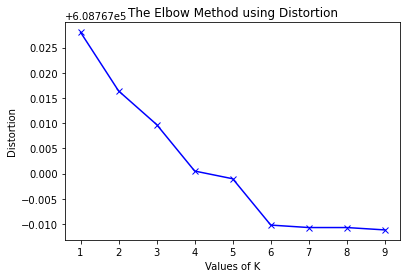

In [19]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

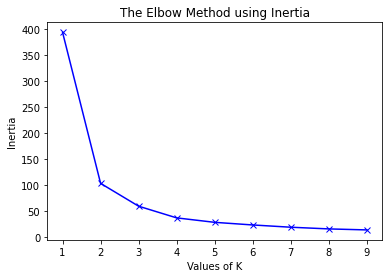

In [20]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

In [21]:
# Silhouette Method
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

euclidean = []
cosine = []
mapping_euclidean = {} 
K = range(1,10)

# Prepare models
for k in K: 
    kmeans = KMeans(n_clusters=6).fit(norm_lrfm)
    normalized_vectors = preprocessing.normalize(norm_lrfm)
    normalized_kmeans = KMeans(n_clusters=4).fit(normalized_vectors)
    min_samples = norm_lrfm.shape[1]+1

    euclidean.append(silhouette_score(norm_lrfm, kmeans.labels_, metric='euclidean'))
    cosine.append(silhouette_score(normalized_vectors, normalized_kmeans.labels_, metric='cosine'))

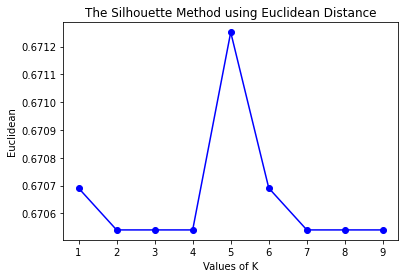

In [22]:
plt.plot(K, euclidean, 'bo-') 
plt.xlabel('Values of K') 
plt.ylabel('Euclidean') 
plt.title('The Silhouette Method using Euclidean Distance') 
plt.show() 

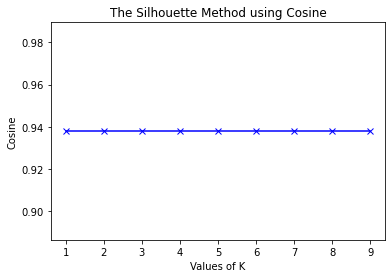

In [23]:
plt.plot(K, cosine, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Cosine') 
plt.title('The Silhouette Method using Cosine') 
plt.show() 

In [24]:
# Silhouette Method
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

# Prepare models
kmeans = KMeans(n_clusters=4).fit(norm_lrfm)
normalized_vectors = preprocessing.normalize(norm_lrfm)
normalized_kmeans = KMeans(n_clusters=4).fit(normalized_vectors)
min_samples = norm_lrfm.shape[1]+1

# Print results
print(silhouette_score(norm_lrfm, kmeans.labels_, metric='euclidean'))
print(silhouette_score(normalized_vectors, normalized_kmeans.labels_, metric='cosine'))

0.6943159606140065
0.9379363981065753


## Cluster!!

In [27]:
def kmeans(normalised_df_lrfm, clusters_number, original_df_lrfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_lrfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_lrfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

def snake_plot(normalised_df_lrfm, df_lrfm_kmeans, df_lrfm_original):

    normalised_df_lrfm = pd.DataFrame(normalised_df_lrfm, 
                                       index=df_lrfm_original.index, 
                                       columns=df_lrfm_original.columns)
    normalised_df_lrfm['Cluster'] = df_lrfm_kmeans['Cluster']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_lrfm.reset_index(), 
                        id_vars=['telp', 'Cluster'],
                        value_vars=['Length', 'Recency', 'Frequency', 'Monetary'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

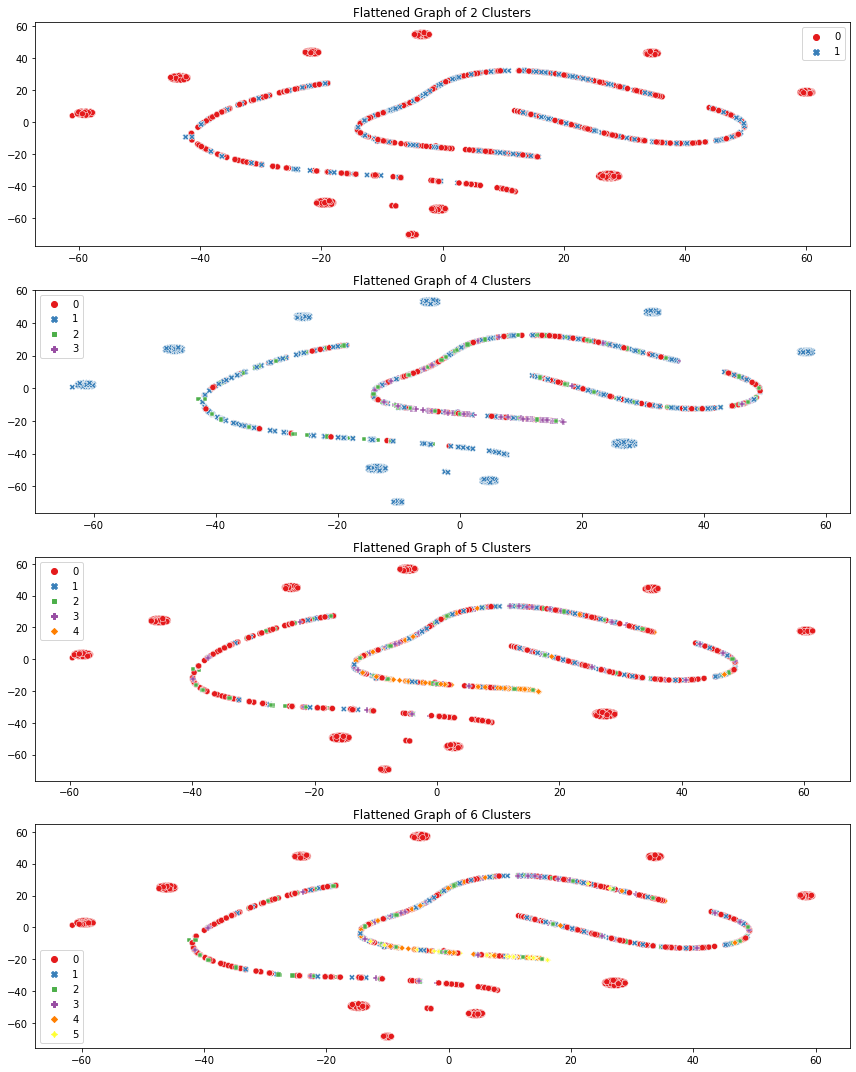

In [29]:
#Scatter Plot
plt.figure(figsize=(12, 15))

plt.subplot(4, 1, 1)
df_lrfm_k2 = kmeans(norm_lrfm, 2, lrfm)

plt.subplot(4, 1, 2)
df_lrfm_k4 = kmeans(norm_lrfm, 4, lrfm)

plt.subplot(4, 1, 3)
df_lrfm_k5 = kmeans(norm_lrfm, 5, lrfm)

plt.subplot(4, 1, 4)
df_lrfm_k6 = kmeans(norm_lrfm, 6, lrfm)

plt.tight_layout()
plt.savefig('flattened.png', format='png', dpi=1000)

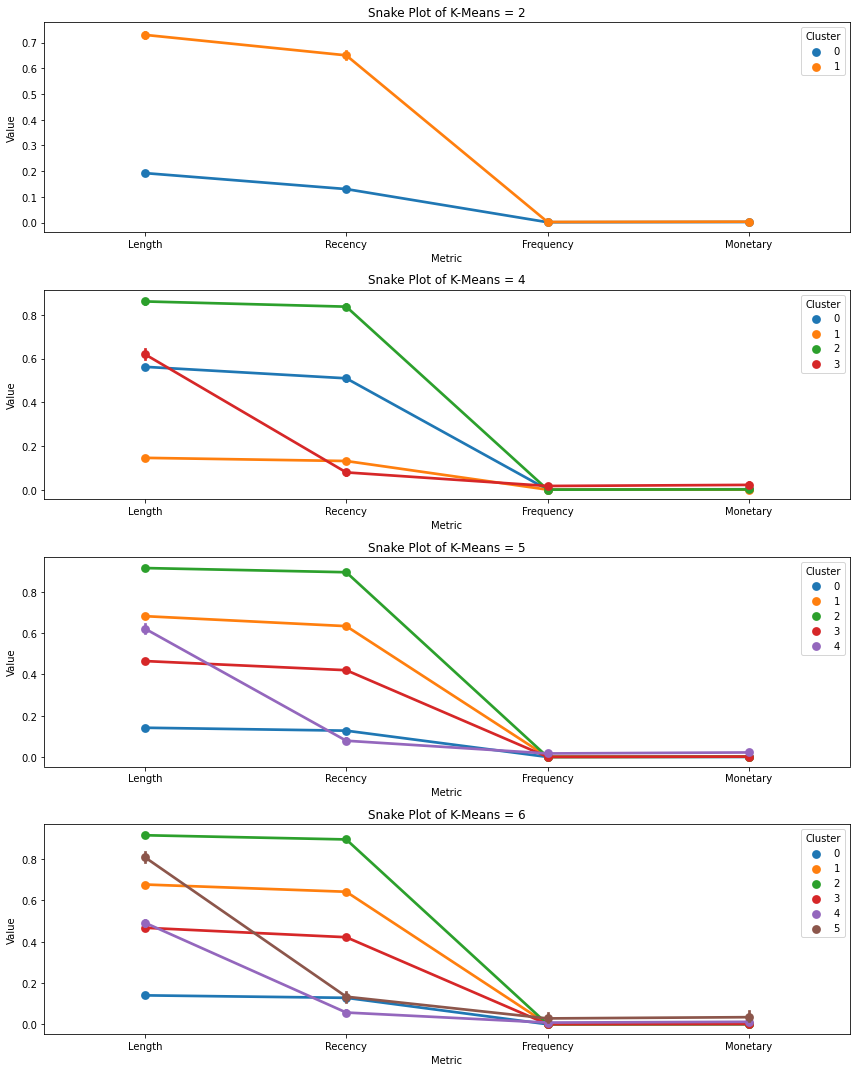

In [30]:
#Snake Plot
plt.figure(figsize=(12, 15))

plt.subplot(4, 1, 1)
plt.title('Snake Plot of K-Means = 2')
snake_plot(norm_lrfm, df_lrfm_k2, lrfm)

plt.subplot(4, 1, 2)
plt.title('Snake Plot of K-Means = 4')
snake_plot(norm_lrfm, df_lrfm_k4, lrfm)

plt.subplot(4, 1, 3)
plt.title('Snake Plot of K-Means = 5')
snake_plot(norm_lrfm, df_lrfm_k5, lrfm)

plt.subplot(4, 1, 4)
plt.title('Snake Plot of K-Means = 6')
snake_plot(norm_lrfm, df_lrfm_k6, lrfm)

plt.tight_layout()

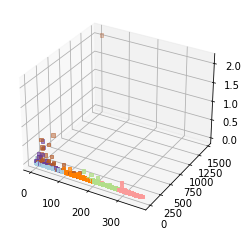

In [31]:
#3D plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.array(df_lrfm_k6['Recency'])
y = np.array(df_lrfm_k6['Frequency'])
z = np.array(df_lrfm_k6['Monetary'])

ax.scatter(x,y,z, marker="s", c=df_lrfm_k6["Cluster"], s=10, cmap="Paired")

plt.show()

# Cluster Analysis

In [ ]:
def lrfm_values(df):

    lrfm_cluster = df.groupby(['Cluster']).agg({
        'Length': 'mean',
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(0)
    
    return lrfm_cluster

In [ ]:
lrfm_values(df_lrfm_k6)